The company of this exercise is a social network. They decided to add a feature called:
Recommended Friends, i.e. they suggest people you may know.
A data scientist has built a model to suggest 5 people to each user. These potential friends will
be shown on the user newsfeed. At first, the model is tested just on a random subset of users to
see how it performs compared to the newsfeed without the new feature.
The test has been running for some time and your boss asks you to check the results. You are
asked to check, for each user, the number of pages visited during their first session since the
test started. If this number increased, the test is a success.

In [34]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import warnings
warnings.simplefilter('ignore')

In [2]:
# import two files
df_user = pd.read_csv('user_table.csv')
df_test = pd.read_csv('test_table.csv')

# merge 
df = pd.merge(left=df_test, right=df_user, on='user_id', how='left')
df['date'] = pd.to_datetime(df['date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        100000 non-null  int64         
 1   date           100000 non-null  datetime64[ns]
 2   browser        100000 non-null  object        
 3   test           100000 non-null  int64         
 4   pages_visited  100000 non-null  int64         
 5   signup_date    100000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 5.3+ MB


In [69]:
df.head()

,user_id,date,browser,test,pages_visited,signup_date,interval,first_day,day_of_week
0,600597,2015-08-13,IE,0,2,2015-01-19,206,0,Thursday
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,107,0,Wednesday
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,52,0,Monday
3,5990330,2015-08-27,Safari,0,8,2015-06-25,63,0,Thursday
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,112,0,Friday


## Data Processing

In [25]:
# create a column to indicate the user is a new uers or not
df['first_day'] = (df['interval']==0).astype(int)

# create a column to indicate the day of week
df['day_of_week'] = df['date'].dt.day_name()
df

,user_id,date,browser,test,pages_visited,signup_date,interval,first_day,day_of_week
0,600597,2015-08-13,IE,0,2,2015-01-19,206,0,Thursday
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,107,0,Wednesday
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,52,0,Monday
3,5990330,2015-08-27,Safari,0,8,2015-06-25,63,0,Thursday
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,112,0,Friday
...,...,...,...,...,...,...,...,...,...
99995,2698493,2015-08-21,Chrome,1,6,2015-03-21,153,0,Friday
99996,3396864,2015-08-04,Chrome,0,5,2015-04-10,116,0,Tuesday
99997,7507573,2015-08-06,IE,1,9,2015-08-06,0,1,Thursday
99998,2316634,2015-08-17,IE,1,7,2015-03-10,160,0,Monday


## Question01
* Is the test winning? That is, should 100% of the users see the Recommended Friends feature?

In [6]:
print('control group sample size: ', len(df.loc[df['test']==0,:]))
print('test group sample size: ', len(df.loc[df['test']==1,:]))
print('control group mean page view: ', df.loc[df['test']==0,'pages_visited'].mean())
print('test group mean page view: ', df.loc[df['test']==1,'pages_visited'].mean())

control group sample size:  49846
test group sample size:  50154
control group mean page view:  4.608393853067447
test group mean page view:  4.599692945727161


In [7]:
# check two groups' mean page visited
page_view_mean = df.groupby('test')['pages_visited'].mean().reset_index()
page_view_mean

,test,pages_visited
0,0,4.608394
1,1,4.599693


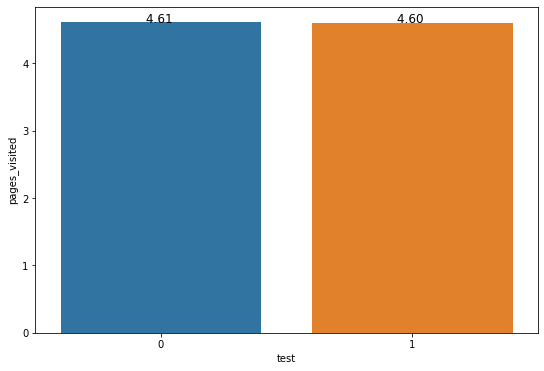

In [74]:
# plot
fig, ax = plt.subplots(figsize=(9,6))

ax = sns.barplot(x='test', y='pages_visited', data=page_view_mean)

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f} '.format((p.get_height()))
            ax.text(_x, _y, value, ha="center", size = 12)            

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)


plt.show()

In [9]:
# define a function do statistic test
def statistic_result(df):
    control = df.loc[df['test']==0,'pages_visited']
    test = df.loc[df['test']==1,'pages_visited']
    
    control_mean = control.mean()
    test_mean = test.mean()
    page_difference = test_mean - control_mean
    
    # t-test
    result = ttest_ind(control, test, equal_var=False)
    
    # based on p-value to draw a conclusion
    conclusion = pd.Series(result.pvalue).apply(lambda x: 'Significant!' if x < 0.05 else 'Not Significant!')[0]

    return pd.Series({'control_sample_size':len(control), 'test_sample_size':len(test), 'control_page_mean': control_mean,
           'test_page_mean': test_mean, 'page_difference': page_difference, 'p_value': result.pvalue, 'Conclusion': conclusion})

In [15]:
result_all = statistic_result(df).reset_index()
result_all = result_all.rename(columns={'index': 'statistic', 0: 'result'})
result_all

,statistic,result
0,control_sample_size,49846
1,test_sample_size,50154
2,control_page_mean,4.60839
3,test_page_mean,4.59969
4,page_difference,-0.00870091
5,p_value,0.577452
6,Conclusion,Not Significant!


* Based on our statistic result, the P-value is way larger than 0.05, so we can say that there is **no significant improvement** in test group

## Question02
* Is the test performing similarly for all user segments or are there differences among different segments?

#### (1) Browser

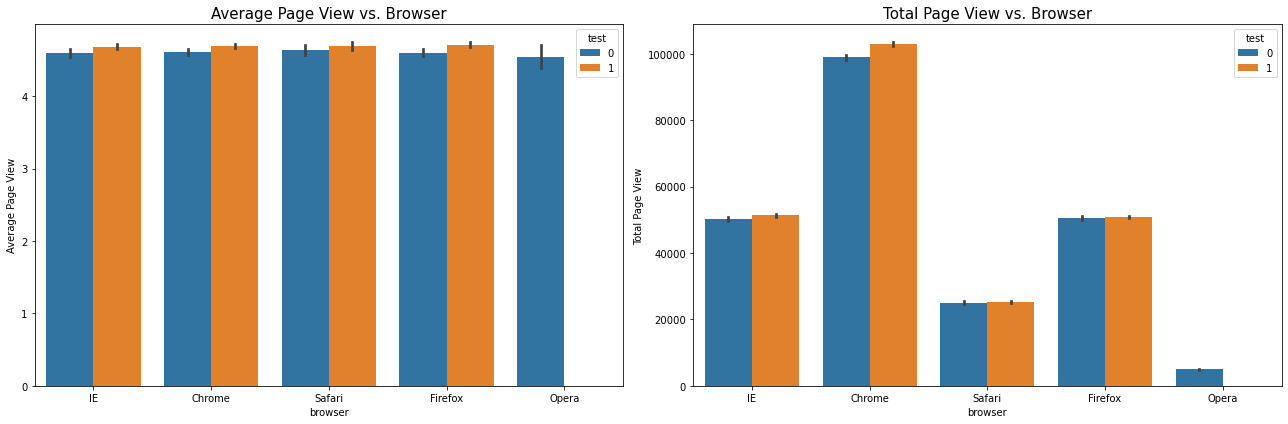

In [43]:
# plots of browser
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.barplot(x='browser', y='pages_visited', hue='test', data=df, ax=ax[0])
ax[0].set_title('Average Page View vs. Browser', fontsize=15)
ax[0].set_ylabel('Average Page View')


sns.barplot(x='browser', y='pages_visited', hue='test', data=df, estimator=sum,ax=ax[1])
ax[1].set_title('Total Page View vs. Browser', fontsize=15)
ax[1].set_ylabel('Total Page View')


plt.tight_layout()
plt.show()

In [17]:
# Browser
df.groupby('browser').apply(statistic_result)

,control_sample_size,test_sample_size,control_page_mean,test_page_mean,page_difference,p_value,Conclusion
browser,,,,,,,
Chrome,21453,21974,4.613341,4.690680,0.077339,9.434084e-04,Significant!
Firefox,10972,10786,4.600164,4.714259,0.114095,5.817199e-04,Significant!
IE,10906,10974,4.598478,4.685985,0.087507,7.829509e-03,Significant!
Opera,1109,1018,4.546438,0.000000,-4.546438,2.252939e-321,Significant!
Safari,5406,5402,4.638180,4.692336,0.054156,2.411738e-01,Not Significant!


* **Chrome**, **Firefox**, and **IE** users show there are **significant improvement** in test group
* For **Opera** browser, the page view mean in test group shows 0, it is very unusual, maybe there are some **technical issues** in test group's Opera
* For **Safari** browser, there is **no significant improvement** in test group

#### (2) First Day

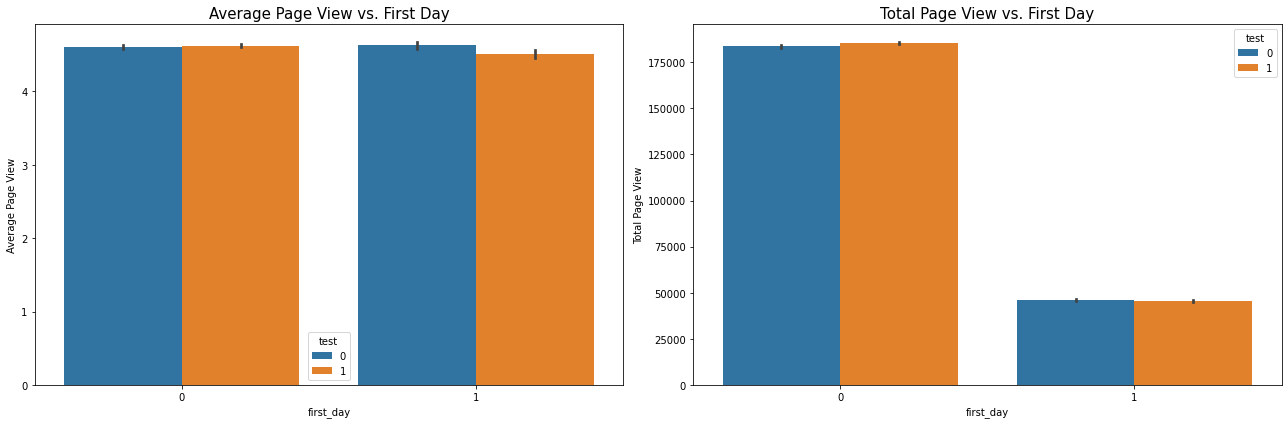

In [47]:
# plots of first day
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.barplot(x='first_day', y='pages_visited', hue='test', data=df, ax=ax[0])
ax[0].set_title('Average Page View vs. First Day', fontsize=15)
ax[0].set_ylabel('Average Page View')


sns.barplot(x='first_day', y='pages_visited', hue='test', data=df, estimator=sum,ax=ax[1])
ax[1].set_title('Total Page View vs. First Day', fontsize=15)
ax[1].set_ylabel('Total Page View')


plt.tight_layout()
plt.show()

In [19]:
# first_day
df.groupby('first_day').apply(statistic_result)

,control_sample_size,test_sample_size,control_page_mean,test_page_mean,page_difference,p_value,Conclusion
first_day,,,,,,,
0,39890,40109,4.603284,4.622379,0.019095,0.261837,Not Significant!
1,9956,10045,4.628867,4.509109,-0.119758,0.001742,Significant!


* For new users, there is a **significant decrease** in test group!
* For old users, there is no significant difference between two groups

#### (3) Day of Week

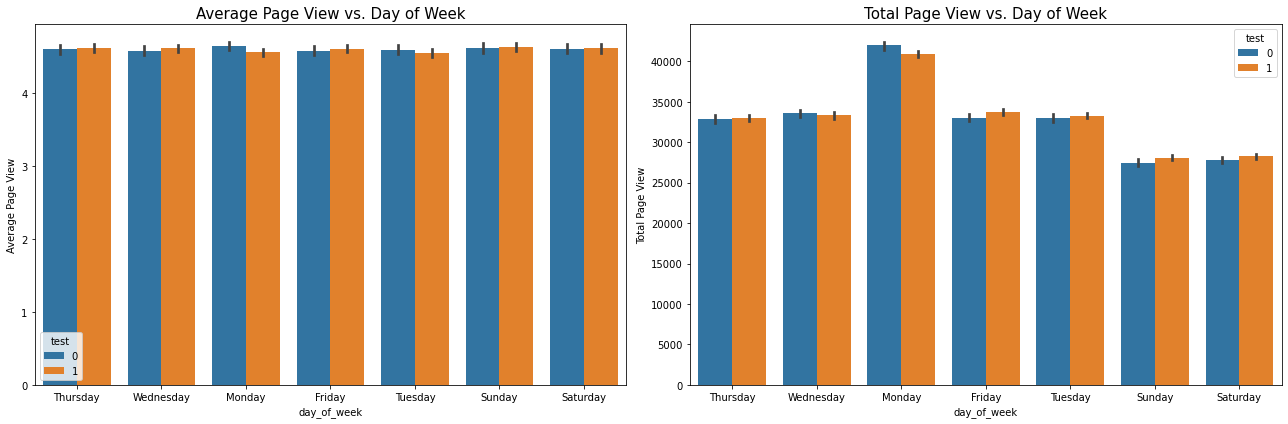

In [50]:
# plots of day of week
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.barplot(x='day_of_week', y='pages_visited', hue='test', data=df, ax=ax[0])
ax[0].set_title('Average Page View vs. Day of Week', fontsize=15)
ax[0].set_ylabel('Average Page View')


sns.barplot(x='day_of_week', y='pages_visited', hue='test', data=df, estimator=sum,ax=ax[1])
ax[1].set_title('Total Page View vs. Day of Week', fontsize=15)
ax[1].set_ylabel('Total Page View')


plt.tight_layout()
plt.show()

In [28]:
# day_of_week
df.groupby('day_of_week').apply(statistic_result)

,control_sample_size,test_sample_size,control_page_mean,test_page_mean,page_difference,p_value,Conclusion
day_of_week,,,,,,,
Friday,7202,7328,4.586643,4.612309,0.025666,0.529504,Not Significant!
Monday,9023,8969,4.650781,4.563942,-0.086839,0.017818,Significant!
Saturday,6026,6120,4.613010,4.615033,0.002022,0.964417,Not Significant!
Sunday,5953,6070,4.618680,4.629489,0.010810,0.811739,Not Significant!
Thursday,7138,7138,4.604091,4.622723,0.018633,0.654807,Not Significant!
Tuesday,7186,7313,4.591845,4.552851,-0.038994,0.337859,Not Significant!
Wednesday,7318,7216,4.585816,4.617932,0.032117,0.430152,Not Significant!


* Only **Monday** shows a significant difference between test and control group. But it is **significant decrease**, which means our test completely failed on Monday.

## Question03
* If you identified segments that responded differently to the test, can you guess the reason? Would this change your point 1 conclusions?

#### Because Opera broswer has some problems that will make our analysis result bias, so we remove it and do analysis again

In [52]:
df_no_op = df.loc[df['browser'] != 'Opera', :]
df_no_op

,user_id,date,browser,test,pages_visited,signup_date,interval,first_day,day_of_week
0,600597,2015-08-13,IE,0,2,2015-01-19,206,0,Thursday
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,107,0,Wednesday
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,52,0,Monday
3,5990330,2015-08-27,Safari,0,8,2015-06-25,63,0,Thursday
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,112,0,Friday
...,...,...,...,...,...,...,...,...,...
99995,2698493,2015-08-21,Chrome,1,6,2015-03-21,153,0,Friday
99996,3396864,2015-08-04,Chrome,0,5,2015-04-10,116,0,Tuesday
99997,7507573,2015-08-06,IE,1,9,2015-08-06,0,1,Thursday
99998,2316634,2015-08-17,IE,1,7,2015-03-10,160,0,Monday


In [54]:
df_no_op['browser'].value_counts()

Chrome     43427
IE         21880
Firefox    21758
Safari     10808
Name: browser, dtype: int64

In [57]:
result_new = statistic_result(df_no_op).reset_index()
result_new = result_new.rename(columns={'index': 'statistic', 0: 'result'})
result_new

,statistic,result
0,control_sample_size,48737
1,test_sample_size,49136
2,control_page_mean,4.6098
3,test_page_mean,4.69499
4,page_difference,0.0851858
5,p_value,4.40395e-08
6,Conclusion,Significant!


* As we can see above, after we remove Opera broswer data, there is a **significant improvement** in test group

#### (1) First day

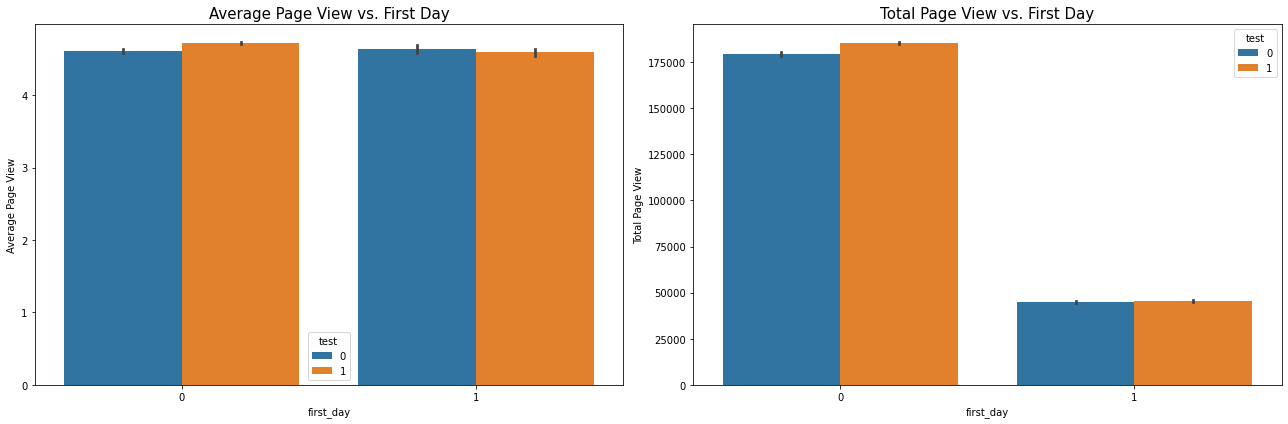

In [58]:
# plots of first day
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.barplot(x='first_day', y='pages_visited', hue='test', data=df_no_op, ax=ax[0])
ax[0].set_title('Average Page View vs. First Day', fontsize=15)
ax[0].set_ylabel('Average Page View')


sns.barplot(x='first_day', y='pages_visited', hue='test', data=df_no_op, estimator=sum,ax=ax[1])
ax[1].set_title('Total Page View vs. First Day', fontsize=15)
ax[1].set_ylabel('Total Page View')


plt.tight_layout()
plt.show()

In [59]:
df_no_op.groupby('first_day').apply(statistic_result)

,control_sample_size,test_sample_size,control_page_mean,test_page_mean,page_difference,p_value,Conclusion
first_day,,,,,,,
0,39007,39276,4.603481,4.720415,0.116933,4.859482e-12,Significant!
1,9730,9860,4.635149,4.593712,-0.041437,2.797387e-01,Not Significant!


* For old users:
    1. There is a **significant improvement** in test group
    2. Maybe because our recommended system can accurately suggest people to old users that they really know based on old users historical data
* For new users
    1. There is **no significant improvement** in test group
    2. Maybe our recommended system only can randomly suggest people to new users because the system doesn't have new users historical data, and if it always suggests the people that new users don't know, it can get annoying, which will reduce the user's desire to continue browsing and decrease the page view



#### (2) Day of week

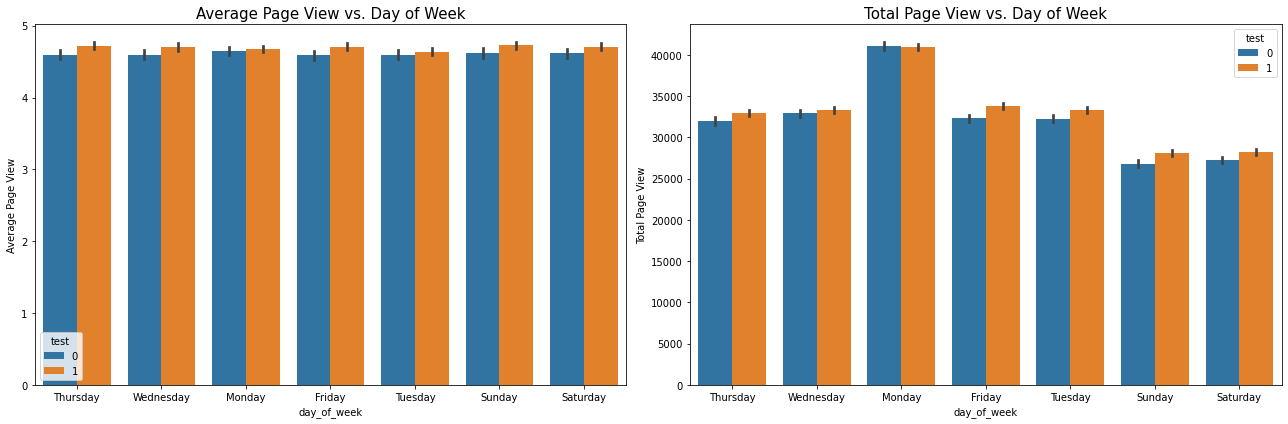

In [60]:
# plots of day of week
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.barplot(x='day_of_week', y='pages_visited', hue='test', data=df_no_op, ax=ax[0])
ax[0].set_title('Average Page View vs. Day of Week', fontsize=15)
ax[0].set_ylabel('Average Page View')


sns.barplot(x='day_of_week', y='pages_visited', hue='test', data=df_no_op, estimator=sum,ax=ax[1])
ax[1].set_title('Total Page View vs. Day of Week', fontsize=15)
ax[1].set_ylabel('Total Page View')


plt.tight_layout()
plt.show()

In [61]:
df_no_op.groupby('day_of_week').apply(statistic_result)

,control_sample_size,test_sample_size,control_page_mean,test_page_mean,page_difference,p_value,Conclusion
day_of_week,,,,,,,
Friday,7040,7177,4.587784,4.709349,0.121565,0.002810,Significant!
Monday,8834,8766,4.652819,4.669633,0.016814,0.644572,Not Significant!
Saturday,5906,5999,4.614291,4.708118,0.093827,0.037674,Significant!
Sunday,5809,5945,4.619900,4.726829,0.106929,0.018126,Significant!
Thursday,6967,6994,4.593656,4.717901,0.124245,0.002761,Significant!
Tuesday,7017,7176,4.597691,4.639771,0.042080,0.300161,Not Significant!
Wednesday,7164,7079,4.594082,4.707303,0.113222,0.005287,Significant!


* As we can see here, after we remove Opera broswer data, our test have **significant improvements** on **Wednesday, Thursday, Friday, Saturday, and Friday**